# Run a QE to estimate the mass of a cluster from a patch of the sky 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import camb 

import lensit as li
from lensit.clusterlens import lensingmap 
from lensit.misc.misc_utils import gauss_beam
from lensit.ffs_covs import ffs_cov, ell_mat

import os
import os.path as op
import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.interpolate import UnivariateSpline as spline



In [2]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)

### 0- We build the simulated maps

In [3]:
# We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = 'planck_2018_acc'

pars = camb.read_ini(op.join(op.dirname(camb.__path__[0]),  'inifiles', cambinifile + '.ini'))
# pars.set_for_lmax(20000)
# pars.set_accuracy(2)
results = camb.get_results(pars)

In [4]:
# We define here the parameters for the profile of the cluster
M200 = 1e15
z = 1
profname = 'nfw'
profparams={'M200c':M200, 'z':z}

# Define here the map square patches
npix = 128  # Number of pixels
lpix_amin = 0.3 # Physical size of a pixel in arcmin (There is bug when <0.2 amin, due to low precision in Cl_TE at )

# Maximum multipole used to generate the CMB maps from the CMB power spectra
# ellmaxsky = 6000 # (bug when ellmax>6300 because of low precision in Cl_TE of CAMB )
ellmaxsky = 70000 

# Set the maximum ell observed in the CMB data maps
ellmaxdat = 3000


# Number of simulated maps 
nsims = 100

# Set CMB experiment for noise level and beam
cmb_exp='S4_opti'

# We will cache things in this directory 
libdir = lensingmap.get_cluster_libdir(cambinifile, profname, npix, lpix_amin, ellmaxsky, M200, z, nsims, cmb_exp)
print(libdir)

/Users/louis/Code/LensIt/lensit_write/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_opti/nfw_profile/npix128_lpix_0.3amin_lmaxsky70000/M200_1.000000E+15_z1/100_sims


In [5]:
camb_cls_len = results.get_lensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=ellmaxsky).T
cls_len = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[3]}
# cpp_true = results.get_lens_potential_cls(CMB_unit='muK', raw_cl=True, lmax=ellmaxsky).T[0]

In [6]:
# Instantiate the class containing the simulated maps 

clustermaps = lensingmap.cluster_maps(libdir, npix, lpix_amin, nsims, results, profparams, profilename=profname,  ellmax_sky = ellmaxsky, ellmax_data=ellmaxdat, cmb_exp=cmb_exp)


/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:248: RuntimeWarning: invalid value encountered in true_divide
  dx_lm = 2 * rfft_kappa * 1.j * KX / (KX**2+KY**2)
/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:249: RuntimeWarning: invalid value encountered in true_divide
  dy_lm = 2 * rfft_kappa * 1.j * KY / (KX**2+KY**2)


In [7]:
def cli(cl):
    ret = np.zeros_like(cl)
    ret[np.where(cl > 0)] = 1. / cl[np.where(cl > 0)]
    return ret

def pp_to_kk(ls):
    return ls ** 2 * (ls+1) ** 2 * 0.25 

def kk_to_pp(ls):
    return cli(pp_to_kk(ls))

### 1. We build the quadratic estimator and initial curvature estimates:

In [8]:
ellmax_sky = clustermaps.ellmax_sky
sN_uKamin, sN_uKaminP, Beam_FWHM_amin, ellmin, ellmax = li.get_config(clustermaps.cmb_exp)

cls_noise = {'t': (sN_uKamin * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'q':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'u':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1)}  # simple flat noise Cls
# cl_transf = gauss_beam(Beam_FWHM_amin / 60. * np.pi / 180., lmax=ellmax_sky)
# lib_alm = ell_mat.ffs_alm_pyFFTW(get_ellmat(LD_res, HD_res=HD_res),
                    # filt_func=lambda ell: (ell >= ellmin) & (ell <= ellmax), num_threads=pyFFTWthreads)
# lib_skyalm = ell_mat.ffs_alm_pyFFTW(clustermaps.ellmat,
                    # filt_func=lambda ell: (ell <= ellmax_sky), num_threads=clustermaps.num_threads)

cl_transf = clustermaps.cl_transf
lib_skyalm = clustermaps.lib_skyalm


typ = 'T'

lib_dir = op.join(clustermaps.dat_libdir, typ)
# isocov = ffs_cov.ffs_diagcov_alm(lib_dir, clustermaps.lib_datalm, clustermaps.cls_unl, cls_len, cl_transf, cls_noise, lib_skyalm=lib_skyalm)
isocov = ffs_cov.ffs_diagcov_alm(lib_dir, clustermaps.lib_datalm, clustermaps.cls_unl, clustermaps.cls_unl, cl_transf, cls_noise, lib_skyalm=lib_skyalm)


In [9]:
ell, = np.where(lib_skyalm.get_Nell()[:ellmaxsky+1])

kappa_map = clustermaps.get_kappa_map(clustermaps.M200, clustermaps.z)

ckk_map = lib_skyalm.map2cl(kappa_map)
cpp_map_interp = 10**spline(ell, np.log10(ckk_map[ell]))(np.arange(ellmaxsky+1)) * kk_to_pp(np.arange(ellmaxsky+1))


kappa_ell = clustermaps.haloprofile.analitic_kappa_ft(clustermaps.M200, clustermaps.z, np.arange(ellmax_sky+1))
ckk_fid = kappa_ell **2 
cpp_fid = kk_to_pp(np.arange(ellmax_sky+1))*ckk_fid


cpp_prior = np.copy(cpp_map_interp)
cpp_prior = cpp_prior[:isocov.lib_skyalm.ellmax +1]


ckk_alm = lib_skyalm.map2alm(kappa_map)

ckk_bin = lib_skyalm.bin_realpart_inell(ckk_alm)
# To bin in disk 

ell, = np.where(clustermaps.lib_datalm.get_Nell()[:ellmaxsky+1])

/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:151: RuntimeWarning: invalid value encountered in subtract
  Cidiff = Cixpc - Cix
/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:152: RuntimeWarning: invalid value encountered in true_divide
  u0 = np.sin(x) * Sidiff + np.cos(x) * Cidiff - np.sin(x * c) / (x * (1. + c))


In [10]:
def get_starting_point(idx, typ, clustermaps): 
    """
    This returns initial data for simulation index 'idx' from a CMB-S4 simulation library.
    On first call the simulation library will generate all simulations phases, hence might take a little while.
    """ 

    print(" I will be using data from ell=%s to ell=%s only"%(isocov.lib_datalm.ellmin, isocov.lib_datalm.ellmax))
    print(" The sky band-limit is ell=%s"%(isocov.lib_skyalm.ellmax))
    # isocov.lib_datalm defines the mode-filtering applied on the data, 
    # and isocov.lib_skyalm the band-limits of the unlensed sky.
    lib_qlm = isocov.lib_skyalm #: This means we will reconstruct the lensing potential for all unlensed sky modes.
    # lib_qlm = isocov.lib_datalm #: This means we will reconstruct the lensing potential for data modes.

    # We now build the Wiener-filtered quadratic estimator. We use lensed CMB spectra in the weights.
    if typ=='QU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in clustermaps.maps_lib.get_sim_qumap(idx)]) 
    elif typ =='T':
        datalms = np.array([isocov.lib_datalm.map2alm(clustermaps.maps_lib.get_sim_tmap(idx))]) 
    
    use_cls_len = False
    
    H0len =  cli(isocov.get_N0cls(typ, lib_qlm, use_cls_len=use_cls_len)[0])
    plm = 0.5 * isocov.get_qlms(typ,  isocov.get_iblms(typ, datalms, use_cls_len=use_cls_len)[0], lib_qlm, 
                                 use_cls_len=use_cls_len)[0]
    
    # Normalization and Wiener-filtering:
    # cpp_prior = li.get_fidcls()[0]['pp'][:lib_qlm.ellmax+1]

    plmqe  = lib_qlm.almxfl(plm, cli(H0len), inplace=False)
    plm0  = lib_qlm.almxfl(plm, cli(H0len + cli(cpp_prior[:lib_qlm.ellmax+1])), inplace=False)
    wf_qe = np.zeros(lib_qlm.ellmax+1)
    ell, = np.where(lib_qlm.get_Nell()[:isocov.lib_datalm.ellmax])
    
    wf_qe[ell] = cpp_prior[ell] * cli(cpp_prior[ell] + cli(H0len[ell]))
    # wf_qe = cpp_prior[:lib_qlm.ellmax+1] * cli(cpp_prior[:lib_qlm.ellmax+1] + cli(H0len[:lib_qlm.ellmax+1]))
    # wf_qe = spline(ell, wf_qe_0[ell])(np.arange(lib_qlm.ellmax+1))


    # Initial likelihood curvature guess. We use here N0 as calculated with unlensed CMB spectra:
    H0unl =  cli(isocov.get_N0cls(typ, lib_qlm, use_cls_len=False)[0])
    return plm0, plmqe, lib_qlm, datalms, isocov.lib_datalm, H0unl, H0len, wf_qe



In [11]:
idx = 0
plm0, plmqe, lib_qlm, datalms, lib_datalm, H0, H0len, wf_qe = get_starting_point(idx, typ, clustermaps)

 I will be using data from ell=0 to ell=2868 only
 The sky band-limit is ell=50911
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  


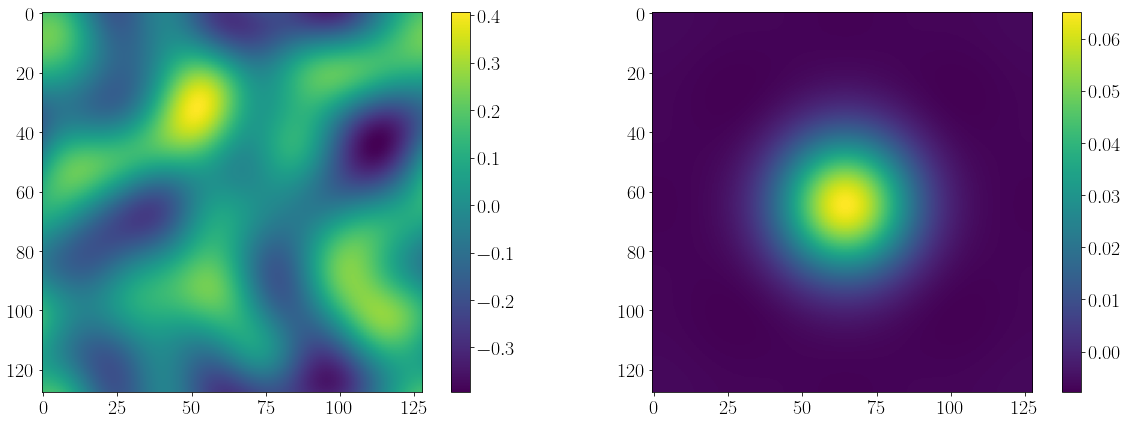

In [12]:
kappa_input = clustermaps.len_cmbs.kappa_map
phi_input = clustermaps.len_cmbs._get_f().get_phi()
klm_input = lib_qlm.map2alm(kappa_input)
plm_input = lib_qlm.map2alm(phi_input)

phi_input_wf = lib_qlm.alm2map(lib_qlm.almxfl(plm_input,  wf_qe , inplace=False))
kappa_input_wf = lib_qlm.alm2map(lib_qlm.almxfl(klm_input,  wf_qe , inplace=False))


kappa_qewf = clustermaps.haloprofile.phimap2kappamap(lib_qlm.alm2map(plm0), lib_skyalm.shape, lib_skyalm.lsides)


fig, axs = plt.subplots(1, 2, figsize=(12, 6),)

fig.subplots_adjust(left=0.02, bottom=0.06, right=1.4, top=0.94, wspace=0.05)
for ax, dat in zip(axs, [kappa_qewf, kappa_input_wf]):
# for ax, dat in zip(axs, [lib_qlm.alm2map(plm0), phi_input_wf]):
    im = ax.imshow(dat)
    fig.colorbar(im, ax=ax)

### 1.2 Make QE on several sims 

In [13]:
nmaps = 50
plmqe_wf = [None]*nmaps
plmqes = [None]*nmaps
phiqe_wf = [None]*nmaps
phiqe = [None]*nmaps
kmaps_wf = [None]*nmaps
kmapsqe = [None]*nmaps
datalms = [None]*nmaps

if nsims >1:
    for idx in range(nmaps):
        print(idx)
        plmqe_wf[idx], plmqes[idx], lib_qlm, datalms[idx], lib_datalm, H0, H0len, wf_qe = get_starting_point(idx, typ, clustermaps)
        phiqe_wf[idx] = lib_qlm.alm2map(plmqe_wf[idx])
        phiqe[idx] = lib_qlm.alm2map(plmqes[idx])
        kmaps_wf[idx] = clustermaps.haloprofile.phimap2kappamap(phiqe_wf[idx], lib_skyalm.shape, lib_skyalm.lsides)
        kmapsqe[idx] = clustermaps.haloprofile.phimap2kappamap(phiqe[idx], lib_skyalm.shape, lib_skyalm.lsides)

0
 I will be using data from ell=0 to ell=2868 only
 The sky band-limit is ell=50911
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
1
 I will be using data from ell=0 to ell=2868 only
 The sky band-limit is ell=50911
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
2
 I will be using data from ell=0 to ell=2868 only
 The sky band-limit is ell=50911
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
3
 I will be using data from ell=0 to ell=2868 only
 The sky band-limit is ell=50911
     [00:00:00]  (total [00

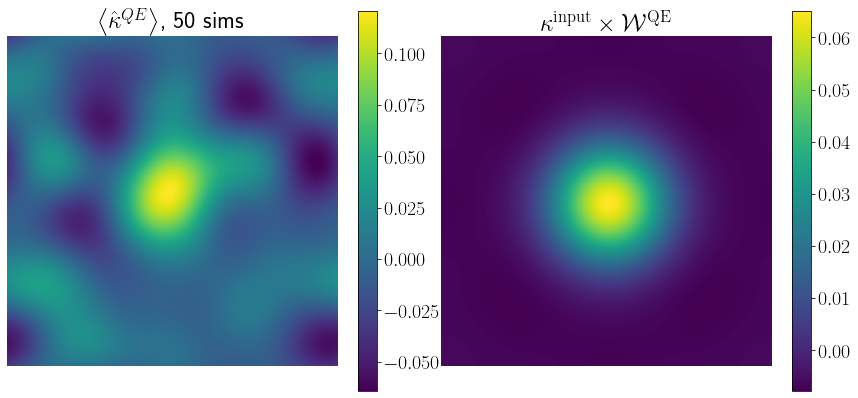

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6),)

fig.subplots_adjust(left=0.02, bottom=0.06, right=1, top=0.94, wspace=0.05)

vmax = np.max(np.abs(phi_input_wf))
titles = [r'$\left< \hat \kappa^{QE} \right>$' + f', {nmaps} sims', r'$\kappa^{\mathrm{input}} \times \mathcal{W}^{\mathrm{QE}} $']
# for ax, dat, title in zip(axs, [np.mean(np.array(phiqe_wf), axis=0), phi_input_wf], titles):
for ax, dat, title in zip(axs, [np.mean(np.array(kmaps_wf), axis=0), kappa_input_wf], titles):
    im = ax.imshow(dat)
    fig.colorbar(im, ax=ax)
    ax.set_title(title)
    ax.axis('off')

In [15]:
def get_profile(map):
    """Return the average of the around teh central pixel"""
    npix = map.shape[0]
    assert map.shape[0]==map.shape[1]

    x0 = npix/2
    yp = npix/2
    

In [16]:
def radial_profile(data, pixsize, center=None):
    """Compute the radial profile of a map around the center pixel.

    data : 2D numpy array
    pixsize : angular size of a pixel in arcmin
    center : The [x,y] pixel coordinates used as the center. The default is
            None, which then uses the center of the image (including
            fracitonal pixels).

    return : theta: angle from center in arcminutes
            radialprofile: radial profile of the stack
            std: std of the values of pixels in each radial ring
    """
    y, x = np.indices(data.shape)
    if not center:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() -y.min()) / 2.0])

    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    theta = np.arange(radialprofile.size) * pixsize

    """Get the standard deviation of pixels in each ring"""
    std = np.zeros(radialprofile.size)
    for i in range(radialprofile.size):
        where = np.where(r.ravel() == i)
        std[i] = np.std(data.ravel()[where])

    return theta, radialprofile, std


In [17]:
theta, kappa_prof, kappa_prof_std = radial_profile(np.mean(np.array(kmaps_wf), axis=0), lpix_amin)
theta, phi_prof, phi_prof_std = radial_profile(np.mean(np.array(phiqe_wf), axis=0), lpix_amin)
theta, phi_prof_fid, _ = radial_profile(phi_input_wf, lpix_amin)



theta, kappa_prof_input, _ =  radial_profile(kappa_input, lpix_amin)
theta, kappa_prof_input_wf, _ =  radial_profile(kappa_input_wf, lpix_amin)

/var/folders/k2/pz579q490y94_cj44cpv_5l80000gn/T/ipykernel_71917/1257435565.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = r.astype(np.int)


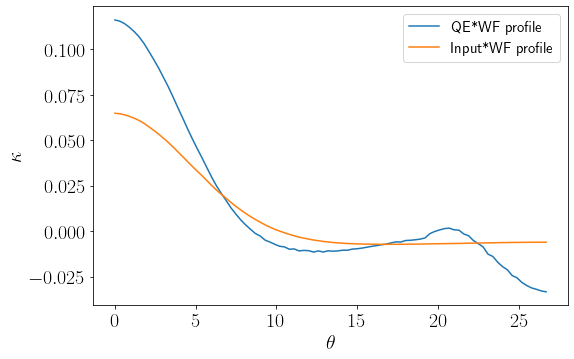

In [18]:
plt.plot(theta, kappa_prof, label='QE*WF profile')
# plt.plot(theta, kappa_prof_input, label='Input profile')
plt.plot(theta, kappa_prof_input_wf, label='Input*WF profile')



plt.xlabel(r'$\theta$')
plt.ylabel(r'$\kappa$')

plt.legend()

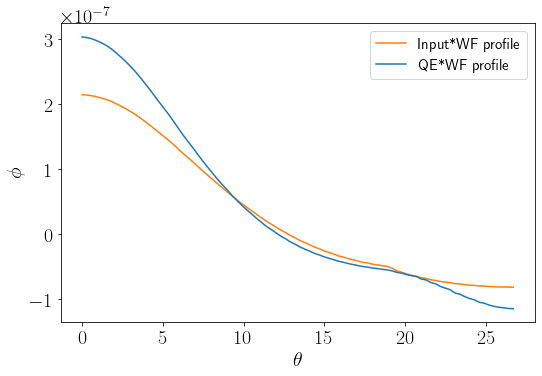

In [19]:
plt.errorbar(theta, phi_prof, label='QE*WF profile')
plt.plot(theta, phi_prof_fid, label='Input*WF profile')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\phi$')

plt.legend()